In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
!pip install arch
import arch
from arch import arch_model
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from arch.univariate.base import DataScaleWarning
warnings.filterwarnings("ignore", category=DataScaleWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.2 MB/s eta 0:00:00


In [2]:
# Definindo os tickers
tickers = ['KLBN11.SA', 'SUZB3.SA', 'ITUB4.SA', 'PETR4.SA']

start_date="2022-01-01"
end_date="2024-12-31"

classeAtivos = 'acoes'
idAcaoVol = 'KLBN11.SA'
#classeAtivos = 'moeda'

if classeAtivos == 'acoes':
  tickers = ['KLBN11.SA', 'SUZB3.SA', 'ITUB4.SA', 'PETR4.SA']
  # Obtendo os dados do Yahoo Finance
  data = yf.download(tickers, start_date,  end_date, interval="1d", auto_adjust= False, actions=False)['Adj Close']
elif classeAtivos == 'moeda':
  tickers = ['BRL=X']
  # Rodar apenas o BRL
  data = yf.download("BRL=X", start=start_date, end=end_date)['Close']



[*********************100%***********************]  4 of 4 completed


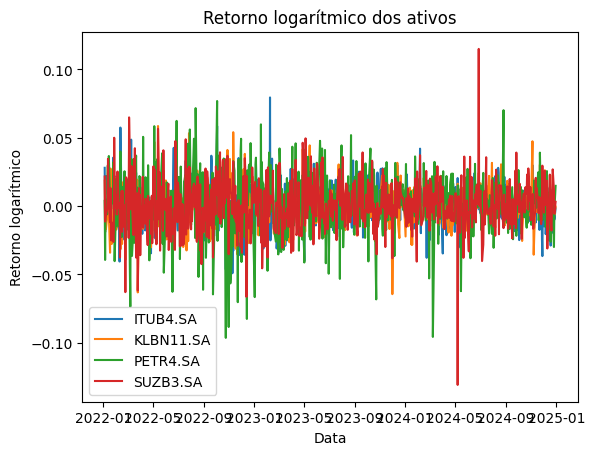

In [3]:
# Calculando os retornos logarítmicos
retornos = np.log(data / data.shift(1)).dropna()
plt.plot(retornos)
plt.title('Retorno logarítmico dos ativos')
plt.legend(retornos.columns)
plt.xlabel('Data')
plt.ylabel('Retorno logarítmico')
plt.show()

In [4]:
#modelo Garch

def func_garch(retornosf, janela, id_ativo):

    # Modelo GARCH(1,1)

    numRetornos = retornosf.shape[0]

    prevGarch = []
    for i in range(numRetornos - janela):
      retornosAtivo = retornosf[id_ativo][i:i+janela]
      model = arch_model(retornosAtivo, mean='Constant', vol='GARCH', p=1, q=1)
      # Ajustar o modelo aos dados
      resultadoGarch = model.fit(disp='off')
      # Previsões de volatilidade
      previsoes_volatilidade = resultadoGarch.forecast(horizon=1).variance.values[0]  # Previsões
      previsoes_volatilidade = np.sqrt(previsoes_volatilidade)
      prevGarch.append(previsoes_volatilidade[0])
    return prevGarch


In [5]:
#modelo EWMA

def ewma_volatility(retornosf, janela, id_ativo, lambda_):
  """
  Calcula a volatilidade utilizando o modelo EWMA.

  Args:
    retornosf: Série de retornos.
    lambda_: Fator de decaimento (0 < lambda_ < 1).

  Returns:
    Série de volatilidades EWMA.
  """

  numRetornos = retornosf.shape[0]

  ewma_volatility = []
  for i in range(numRetornos - janela):
    retornosAtivo = retornosf[id_ativo][i:i+janela]
    # Inicialização da variância
    ewma_variance = retornosAtivo.var()

    # Cálculo da variância EWMA

    for t in range(1, len(retornosAtivo)):
      ewma_variance = (1-lambda_) * retornosAtivo[t]**2 +  lambda_ * ewma_variance

    # Calcular a volatilidade EWMA (raiz quadrada da variância)
    ewma_volatility.append(np.sqrt(ewma_variance))

  return ewma_volatility

In [ ]:
janela = 100
if classeAtivos == 'acoes':
  id_ativo = idAcaoVol
elif classeAtivos == 'moeda':
  id_ativo = 'BRL=X'


vol_model = 'ewma'

vol_est = []
if vol_model == 'garch':
  #Chama Garch
  vol_est = func_garch(retornos, janela, id_ativo)
elif vol_model == 'ewma':
  #Chama EWMA
  vol_est = ewma_volatility(retornos, janela, id_ativo, 0.94)

print(len(vol_est))
numRetornos = retornos.shape[0]
retornosAtivoObs = []
datas = []
for i in range(numRetornos - janela):
  retornosAtivoObs.append(retornos[id_ativo][i+janela])
  datas.append(retornos.index[i+janela])



<ipython-input-31-04088f8809a6>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ewma_variance = (1-lambda_) * retornosAtivo[t]**2 +  lambda_ * ewma_variance


648


<ipython-input-62-9ffa0de70aa7>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  retornosAtivoObs.append(retornos[id_ativo][i+janela])


<class 'list'>


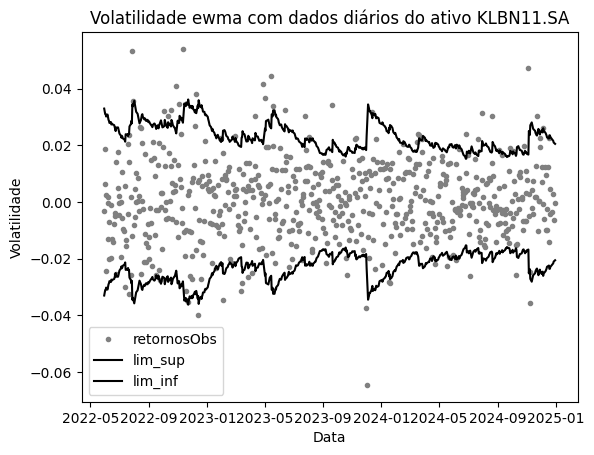

4.012345679012346


In [ ]:
print(type(retornosAtivoObs))
vol_est = pd.DataFrame(vol_est)

vol_est.index = datas
vol_est.columns = ['lim_sup']

vol_est1 = vol_est.copy()*1.645
vol_est1['lim_inf'] = vol_est1['lim_sup'] * (-1)
vol_est1['retornosObs'] = retornosAtivoObs
plt.plot(vol_est1['retornosObs'], '.', color = 'grey', label = 'retornosObs')
plt.plot(vol_est1['lim_sup'], label = 'lim_sup', color = 'black')
plt.plot(vol_est1['lim_inf'], label = 'lim_inf', color = 'black')
plt.legend()
plt.title(f'Volatilidade {vol_model} com dados diários do ativo {id_ativo}')
plt.xlabel('Data')
plt.ylabel('Volatilidade')
plt.show()

# Comparando as colunas e contando as observações onde B < A
count_less_than = (vol_est1['retornosObs'] < vol_est1['lim_inf']).sum()

print(count_less_than/len(vol_est1)*100)

-0.022714778093731475
648


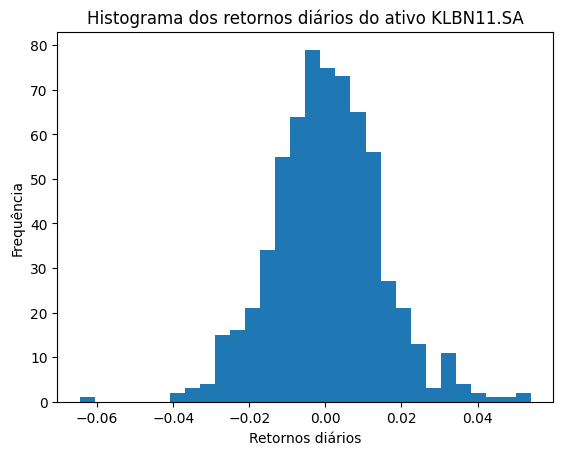

In [ ]:
plt.hist(vol_est1['retornosObs'], bins=30)
plt.title(f'Histograma dos retornos diários do ativo {id_ativo}')
plt.xlabel('Retornos diários')
plt.ylabel('Frequência')
print(vol_est1['retornosObs'].quantile(0.05))
print(len(vol_est1['retornosObs']))